<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

<h1>Analyze data and build a dashboard with Spark, notebooks, and PixieDust</h1> <br/>

Interactive notebooks are powerful tools for fast and flexible experimentation and data analysis. Notebooks can contain live code, static text, equations and visualizations. 

In this lab, we will walk through how to use PixieDust with Spark and notebooks to:
- Analyze open data around traffic accidents in San Francisco
- Build charts and maps to discover insights

We will then show how to:
- Build a dashboard that drills down into specific areas
- Combine multiple data sources like crime or speeding zones to extract even more insights  

![pixiedust](https://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2017/03/pixiedust200.png)

Learn more about PixieDust [Here](https://www.ibm.com/analytics/us/en/watson-data-platform/pixiedust/).

You can access the complete tutorial with step by step instructions here: <a href="https://www.slideshare.net/DTAIEB/pixie-dust-overview" target="_blank" rel="noopener no referrer">PixieDust overview</a>.

This notebook runs on Python with Spark 2.1.

## Table of contents
1. [Install PixieDust](#install)
2. [Import San Francisco traffic accidents data into the notebook](#import)
3. [Explore the data for immediate insights](#explore)
4. [More data exploration and hypothesis](#morexplore)
5. [Focus on the Taraval police district using some friendly SQL notation](#taravalpolice)
6. [Further questions](#furtherquestions)
7. [Build the PixieApp Dashboard](#dashboard)


## 1. Install PixieDust <a class="anchor" id="install"></a>

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

In [ ]:
!pip uninstall pixiedust -y


We install the prerequisites using the `!pip install` syntax.
If instructed to restart the kernel, from the notebook toolbar menu: 
1. Go to **Kernel**, **Restart**. 
2. Click **Restart** in the confirmation dialog.

**Note:** The status of the kernel briefly flashes near the upper right corner, alerting when it is Not Connected, Restarting, Ready, etc. 

Before you can use the PixieDust library it must be imported into the notebook.

In [ ]:
!pip install --user --upgrade pixiedust

In [4]:
import pixiedust

Pixiedust database opened successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


## 2. Import San Francisco traffic accidents data into the notebook<a class="anchor" id="import"></a>
Source: <a href="https://datasf.org/opendata" target="_blank" rel="noopener no referrer">San Francisco Open Data</a>
> Take a moment to explore all the data available at this site

With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook.


In [5]:
# With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook.

accidents = pixiedust.sampleData("https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD")

Downloaded 241673 bytes
Creating pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'


## 3. Explore the data for immediate insights<a class="anchor" id="explore"></a>

After successfully importing PixieDust and loading the sample data, we can use the **display** API to quickly browse through and visualize the data to see if we can obtain any immediate insights.  

For example:

**Explore the schema and browse the data**

>  Select _DataFrame Table_ icon in the display widget


**In which police district do the most traffic accidents occur?**

> Choose the _Chart_ icon in the display widget and select `(Pie Chart - Options: Keys = PdDistrict, Values = IncidntNum, Aggregation = Count)`

We can also dig one level deeper by clustering by how each accident was resolved:

> Choose the _Chart_ icon in the display widget and select `(Bar Chart - Options: Keys = PdDistrict, Values = IncidntNum, Aggregation = Count - Cluster By: Resolution)`

**On what day of the week do the most traffic accidents occur?**

> Choose the _Chart_ icon in the display widget and select `(Bar Chart - Options: Keys = DayOfWeek, Values = IncidntNum, Aggregation = Count)`

Take a moment to explore the possibility of the Display API by watching this <a href="https://www.youtube.com/watch?v=FoOHFlkCaXI" target="_blank" rel="noopener no referrer">Video</a>.

In [ ]:
display(accidents)

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Hour,Res
170521821,NON-CRIMINAL,TRAFFIC ACCIDENT,6-Sat,06/24/2017,18:34,RICHMOND,"ARREST, BOOKED",GREAT HY / FULTON ST,-122.511054248,37.7713387827,"(37.771338782657786, -122.51105424825789)",17052182168050,18,Arrest
170503211,NON-CRIMINAL,TRAFFIC ACCIDENT,2-Tues,06/20/2017,17:34,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403404791,37.7754207067,"(37.775420706711, -122.40340479147905)",17050321168050,17,No Resolution
170492567,NON-CRIMINAL,TRAFFIC ACCIDENT,5-Fri,06/16/2017,21:37,MISSION,"ARREST, BOOKED",1000 Block of POTRERO AV,-122.406681057,37.7553430954,"(37.755343095442036, -122.40668105726543)",17049256768050,21,Arrest
170492250,NON-CRIMINAL,TRAFFIC ACCIDENT,5-Fri,06/16/2017,20:37,CENTRAL,"ARREST, BOOKED",COLUMBUS AV / PACIFIC AV,-122.405517223,37.7970642285,"(37.79706422849924, -122.40551722327726)",17049225068050,20,Arrest
170485299,NON-CRIMINAL,TRAFFIC ACCIDENT,3-Wed,06/14/2017,15:45,TARAVAL,"ARREST, BOOKED",OCEAN AV / DORADO TR,-122.461208521,37.7249502488,"(37.72495024876397, -122.46120852061303)",17048529968050,15,Arrest
170476925,NON-CRIMINAL,TRAFFIC ACCIDENT,7-Sun,06/11/2017,15:01,MISSION,"ARREST, BOOKED",ALABAMA ST / CESAR CHAVEZ ST,-122.410549322,37.7483157743,"(37.748315774286205, -122.41054932172108)",17047692568050,15,Arrest
170472923,NON-CRIMINAL,TRAFFIC ACCIDENT,5-Fri,06/09/2017,23:22,RICHMOND,"ARREST, BOOKED",200 Block of 22ND AV,-122.481793371,37.7830733544,"(37.78307335442143, -122.48179337083826)",17047292368050,23,Arrest
170472155,NON-CRIMINAL,TRAFFIC ACCIDENT,5-Fri,06/09/2017,16:38,SOUTHERN,"ARREST, BOOKED",HARRISON ST / 2ND ST,-122.395163154,37.7843096999,"(37.78430969986759, -122.39516315448759)",17047215568050,16,Arrest
170457549,NON-CRIMINAL,TRAFFIC ACCIDENT,7-Sun,06/04/2017,18:44,RICHMOND,"ARREST, BOOKED",FULTON ST / 8TH AV,-122.46588265,37.7733973258,"(37.773397325817434, -122.46588265028946)",17045754968050,18,Arrest
170455214,NON-CRIMINAL,TRAFFIC ACCIDENT,6-Sat,06/03/2017,16:30,PARK,NONE,1500 Block of OAK ST,-122.44489765,37.7722400208,"(37.77224002075491, -122.4448976496299)",17045521468050,16,No Resolution


## 4. More data exploration and hypothesis<a class="anchor" id="moreexplore"></a>
We are able to immediately identify a couple of areas of interest in our data without writing a single line of code:

- Most accidents happen in the Southern and Taraval police districts

- Most accidents happen on Wednesdays and Thursdays

We can also see that our data needs some cleansing if we want to make analysis easier. Specifically:

- The `Time` field is a string, so we'll need to add an `Hour` column if we want to see the time of day when most accidents occur
- The `DayOfWeek` values are rendered in alphabetical order by default instead of chronological order, so we should rename them to make it easier to see how the number of accidents changes over the course of the week
- We should condense the outcome types of each traffic accident if we want to see the most common resolutions of traffic accidents in each police district, because the clustering above was unclear

Let's cleanse the data and re-investigate before moving on:

**Note**: the next cell is using PySpark APIs to manipulate the data. You can find more information on these APIs <a href="http://spark.apache.org/docs/1.6.0/api/python/pyspark.sql.html" target="_blank" rel="noopener no referrer">here</a>.

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Get the hour value of a time string
# e.g. getHour("05:30") = 5
def getHour(s):
    return int(s.split(':')[0])

hr_udf = udf(getHour,IntegerType())

# Rename weekdays to enable mini time-series analysis
accidents = accidents.na.replace\
    (['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],\
    ['1-Mon','2-Tues','3-Wed','4-Thur','5-Fri','6-Sat','7-Sun'],\
    'DayOfWeek')

# Add Hour column and refine outcomes from traffic accidents
accidents = accidents.withColumn("Hour",hr_udf(accidents['Time']))\
    .withColumn("Res",\
    udf(lambda x: 'Arrest' if 'ARREST' in x else 'No Resolution' if x == 'NONE' else 'Other',StringType())\
    (accidents['Resolution']))


### We are now ready for more data exploration
**Hypothesis: Do accidents in one police district result in more arrests than other police districts?**

```
(Bar Chart - Options: Keys = PdDistrict, Values = IncidntNum, Aggregation = Count, Cluster By: Res)
```

**Question: How does the number of accidents change over the course of the week?**

```
(Line Chart - Options: Keys = DayOfWeek, Values = IncidntNum, Aggregation = Count)
```


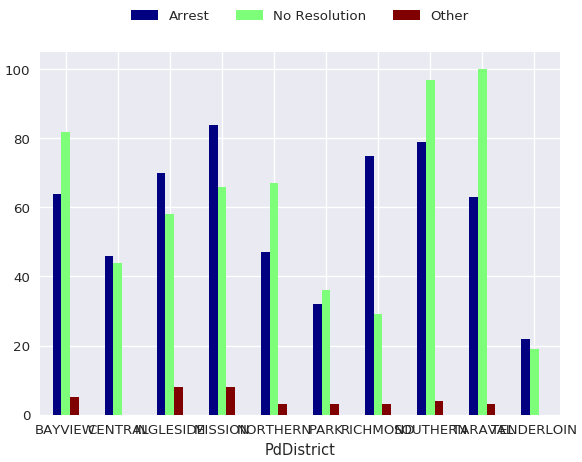

In [13]:
display(accidents)

### What have we learned
A few lines of code makes it a lot easier to see that:

- Accidents in the Mission police district are much more likely to result in arrest than all other districts

- The number of accidents peaks during the middle of the week, but decreases afterwards as the week winds down

## 5. Focus on the Taraval police district using some friendly SQL notation<a class="anchor" id="taravalpolice"></a>

In [9]:
accidents.registerTempTable("accidents")
taraval = sqlContext.sql("SELECT * FROM accidents WHERE PdDistrict='TARAVAL'")

**Question: Where in Taraval do most accidents happen?**

```
(Map - Options: Keys = [X,Y], Values = IncidntNum, Aggregation = Count,
Renderer: mapbox, kind: chloropleth-cluster)
```

**Question: What time of day do most accidents occur?**

```
(Line Chart - Options: Keys = Hour, Values = IncidntNum, Aggregation = Count)
```

In [ ]:
display(taraval)

### What have we learned
Most of the results from looking at the accident times are unsurprising:

- Fewer accidents during very early morning (people probably sleeping)
- Steady increase in number of accidents during morning commuting hours
- Fewer accidents during mid-evening (people probably eating dinner)
- (Sadly) more accidents late at night

The interesting thing here is the sudden spike in accidents during mid-afternoon (2-3PM) - twice as many accidents happen during this two-hour window!

## 6. Further questions<a class="anchor" id="furtherquestions"></a>

In analyzing the geographical data, we can see a couple of clusters where accidents occur more frequently in Taraval - the southeastern corner looks particularly crowded. Some useful questions to ask at this point are:

**- Does crime have an effect on the number of accidents?**

**- Are there more accidents in these areas because more people speed there?**

**- Do traffic calming devices reduce the number of accidents?**

We can test these hypotheses in two ways:

- Download datasets for speeding data and traffic calming in San Francisco and use the `display` API to visualize speeding zones and areas with traffic calming devices separately

- Build a **Pixie App**, which encapsulates everything we have discussed thus far into an interactive way to explore multiple views of the data

Only basic HTML and JavaScript are needed to write a Pixie App, so you don't have to learn any new languages or frameworks. A Pixie App will allow us to overlay mapping layers, and therefore give us a clearer view into the problem we are investigating.

## Build the PixieApp Dashboard<a class="anchor" id="dashboard"></a>

### What you'll need
- Mapbox layers Documentation: <a href="https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-circle" target="_blank" rel="noopener no referrer">Circle</a>, <a href="https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-fill" target="_blank" rel="noopener no referrer">Fill</a>, <a href="https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-symbol" target="_blank" rel="noopener no referrer">Symbols</a> 
- <a href="https://www.mapbox.com/maki-icons" target="_blank" rel="noopener no referrer">Mapbox Maki Icons</a>
- Browse the data on <a href="https://datasf.org/opendata" target="_blank" rel="noopener no referrer">San Francisco Open Data</a> to get the GeoJSON url
- Some understanding of <a href="http://jinja.pocoo.org/docs/dev/templates" target="_blank" rel="noopener no referrer">Jinja2 template</a>
- A Quick read of <a href="https://ibm-cds-labs.github.io/pixiedust/pixieapps.html" target="_blank" rel="noopener no referrer">PixieApp documentation</a>

### FAQ about the code in the section below
- How do I get the pixiedust options in `self.mapJSONOptions`?
> 1. Call `display()` on a new cell.  
> 2. Graphically select the options for your chart.  
> 3. Select **View**, **Cell Toolbar**, **Edit Metadata** menu.  
> 4. Click the **Edit Metadata** button and copy the pixiedust metadata.  
- What's the `self.setLayers` call for?
> This is a method from the MapboxBase class used to specify the custom layer definitions array.  
> The fields are:  
>  - name: Layer name  
>  - url: geojson url to download the data from
>  - type: (optional) style type, for example,  Symbol. If not defined, the default value is infered from geojson geometry
>  - paint: (optional) paint style, see appropriate documentation, for example, <a href="https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-circle" target="_blank" rel="noopener no referrer">Circle</a> 
>  - layout: (optional) layout style, see appropriate documentation, for example, <a href="https://www.mapbox.com/mapbox-gl-js/style-spec/#layers-fill" target="_blank" rel="noopener no referrer">Fill</a>
- How do I find new layer data to add?
> Go to <a href="https://datasf.org/opendata" target="_blank" rel="noopener no referrer">San Francisco Open Data</a>, browse the data and click the **export** button. You should see a geojson link among others (warning: not all datasets have a geojson link, if you don't find it, then move on to another one)
- What does the `mainScreen` method do?
> This is a PixieApp View associated with the default route. See <a href="https://ibm-cds-labs.github.io/pixiedust/pixieapps.html" target="_blank" rel="noopener no referrer">PixieApp documentation</a> for more information.
- What's the {{...}} notation in the mainScreen markup for?
> This is a Jinja2 template notation to call server-side Python code. See <a href="http://jinja.pocoo.org/docs/dev/templates" target="_blank" rel="noopener no referrer">Jinja2 template</a> for more information

In [14]:
from pixiedust.display.app import *
from pixiedust.apps.mapboxBase import MapboxBase

@PixieApp
class SFDashboard(MapboxBase):
    def setup(self):
        self.mapJSONOptions = {
          "mapboxtoken": "pk.eyJ1IjoicmFqcnNpbmdoIiwiYSI6ImNqM2s4ZDg4djAwcGYyd3BwaGxwaDV3bWoifQ.d5Rklkdu5MeGAnXu1GMNYw",
          "chartsize": "90",
          "aggregation": "SUM",
          "rowCount": "500",
          "handlerId": "mapView",
          "rendererId": "mapbox",
          "valueFields": "IncidntNum",
          "keyFields": "X,Y",
          "basemap": "light-v9"
        }
        self.setLayers([
        {
            "name": "Speeding",
            "url": "https://data.sfgov.org/api/geospatial/mfjz-pnye?method=export&format=GeoJSON"
        },
        {
            "name": "Traffic calming",
            "url": "https://data.sfgov.org/api/geospatial/ddye-rism?method=export&format=GeoJSON",
            "type": "symbol",
            "layout": {
                "icon-image": "police-15",
                "icon-size": 1.5
            }
        },
        {
            "name": "Police Districts",
            "url": "https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=GeoJSON"
        },
        {
            "name": "Crimes",
            "url": "https://data.sfgov.org/api/geospatial/ms8q-rzqw?method=export&format=GeoJSON",
            "paint":{
                "fill-color": "rgba(255,182,193,0.5)"
            }
        }
        ])
        
    def formatOptions(self,options):
        return ';'.join(["{}={}".format(key,value) for (key, value) in iteritems(options)])
    
    @route()
    def mainScreen(self):
        return """
<div class="well">
    <center><span style="font-size:x-large">Analyzing San Francisco Public Safety data with PixieDust</span></center>
    <center><span style="font-size:large"><a href="https://datasf.org/opendata" target="new">https://datasf.org/opendata</a></span></center>
</div>
<div class="row">
    <div class="form-group col-sm-2" style="padding-right:10px;">
        <div><strong>Layers</strong></div>
        {% for layer in this.layers %}
        <div class="rendererOpt checkbox checkbox-primary">
            <input type="checkbox" pd_refresh="map{{prefix}}" pd_script="self.toggleLayer({{loop.index0}})">
            <label>{{layer["name"]}}</label>
        </div>      
        {%endfor%}
    </div>
    <div class="form-group col-sm-10">
        <div id="map{{prefix}}" pd_entity pd_options="{{this.formatOptions(this.mapJSONOptions)}}"/>
    </div>
</div>
"""
    
SFDashboard().run(accidents,runInDialog="false")

### Learn more about PixieDust
If you'd like to learn more about other PixieDust features explore the [Welcome to PixieDust notebook](https://apsportal.ibm.com/exchange/public/entry/view/5b000ed5abda694232eb5be84c3dd7c1).

### Authors
**David Taieb** is a Distinguished Engineer at IBM.

Copyright &copy; IBM Corp. 2017, 2018. This notebook and its source code are released under the terms of the Apache License, Version 2.0.